In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

tbl = pd.read_csv('../ums_viz.csv', parse_dates = [1, 4, 12])
desc_tbl = pd.read_pickle('descriptions.pkl')
cat_tbl = pd.read_pickle('categories.pkl')
desc_tbl = desc_tbl.join(cat_tbl)
desc_tbl['title'] = desc_tbl['title'].apply(lambda x: x.strip())

# Filter out 2014 performances
tbl = tbl[tbl['perf_dt']<np.datetime64('2014')]
desc_tbl = desc_tbl[desc_tbl['title'].apply(lambda x: np.any(tbl['perf_name'].eq(x)))]
date_tbl = tbl.groupby('perf_name')['perf_dt'].min().reset_index().rename(columns={'perf_name': 'title'})

desc_tbl.set_index('title')
date_tbl.set_index('title')

desc_tbl = desc_tbl.join(date_tbl, how='inner', rsuffix='_')
desc_tbl = desc_tbl.drop('title_', axis = 1)

In [3]:
# How well do our categories align with subscription series?

# First, let's see which price types correspond to subscription series
print tbl[tbl['mode_of_sale']=='Subscription']['price_type'].value_counts()

# Choral Union <-> Choral
# Chamber Arts <-> Chamber
# Dance Series <-> Dance
# Theater Series <-> Theater
# Jazz Series <-> Jazz

Choral Union                    8048
Series: You                     7006
UMS Subscriber - Add On         2888
Chamber Arts                    2125
Dance Series                     980
Theater Series                   824
Adult                            817
Jazz Series                      458
Divine Voices                    247
Comp                             114
Global Series                     78
Asia Series                       36
National Theatre Live Series      25
Marathon Series                   17
Adult inc 1                        4
Child                              2
Name: price_type, dtype: int64


In [22]:
desc_tbl['Choral_Union'] = desc_tbl['title'].apply(lambda x: np.any(tbl[tbl['perf_name']==x]['price_type'].eq('Choral Union')))
desc_tbl['Chamber_Arts'] = desc_tbl['title'].apply(lambda x: np.any(tbl[tbl['perf_name']==x]['price_type'].eq('Chamber Arts')))
desc_tbl['Dance_Series'] = desc_tbl['title'].apply(lambda x: np.any(tbl[tbl['perf_name']==x]['price_type'].eq('Dance Series')))
desc_tbl['Theater_Series'] = desc_tbl['title'].apply(lambda x: np.any(tbl[tbl['perf_name']==x]['price_type'].eq('Theater Series')))
desc_tbl['Jazz_Series'] = desc_tbl['title'].apply(lambda x: np.any(tbl[tbl['perf_name']==x]['price_type'].eq('Jazz Series')))
desc_tbl['National_Theatre_Live'] = desc_tbl['title'].apply(lambda x: np.any(tbl[tbl['perf_name']==x]['price_type'].eq('National Theatre Live Series')))


# Whoops
desc_tbl[desc_tbl['title']=='Charles Lloyd Quarte'].loc[96, 'category'] = 'Jazz'
#desc_tbl[desc_tbl['title']=='Charles Lloyd Quarte'].loc[96, 'category']

for series in ['Choral_Union', 'Chamber_Arts', 'Dance_Series', 'Theater_Series', 'Jazz_Series', 'National_Theatre_Live']:
    series_tbl = desc_tbl[desc_tbl[series]]
    print series
    print series_tbl['category'].value_counts()
    print desc_tbl[desc_tbl[series]][['title', 'category']]
    


Choral_Union
Orchestra    10
Chamber       6
Choral        1
Theater       1
Other         1
Name: category, dtype: int64
                   title   category
0    The Infernal Comedy    Theater
1       Yuja Wang, piano    Chamber
2    London Philharmonic  Orchestra
3       Hamburg Symphony  Orchestra
4   Chicago Symphony Orc  Orchestra
5   San Francisco Sympho  Orchestra
8            Joshua Bell  Orchestra
9         Murray Perahia    Chamber
10   Mariinsky Orchestra  Orchestra
11  Detroit Symphony Orc  Orchestra
12  New York Philharmoni  Orchestra
14   Anne-Sophie Mutter,    Chamber
16         Alison Balsom    Chamber
18        Audra McDonald      Other
19  Andras Schiff, piano    Chamber
20         Apollo's Fire  Orchestra
28  Denis Matsuev, piano    Chamber
29    Handel's Radamisto     Choral
30   Milhaud's Oresteian  Orchestra
Chamber_Arts
Chamber      12
Other         1
Orchestra     1
Name: category, dtype: int64
                    title   category
6      Pavel Haas Quartet    Ch

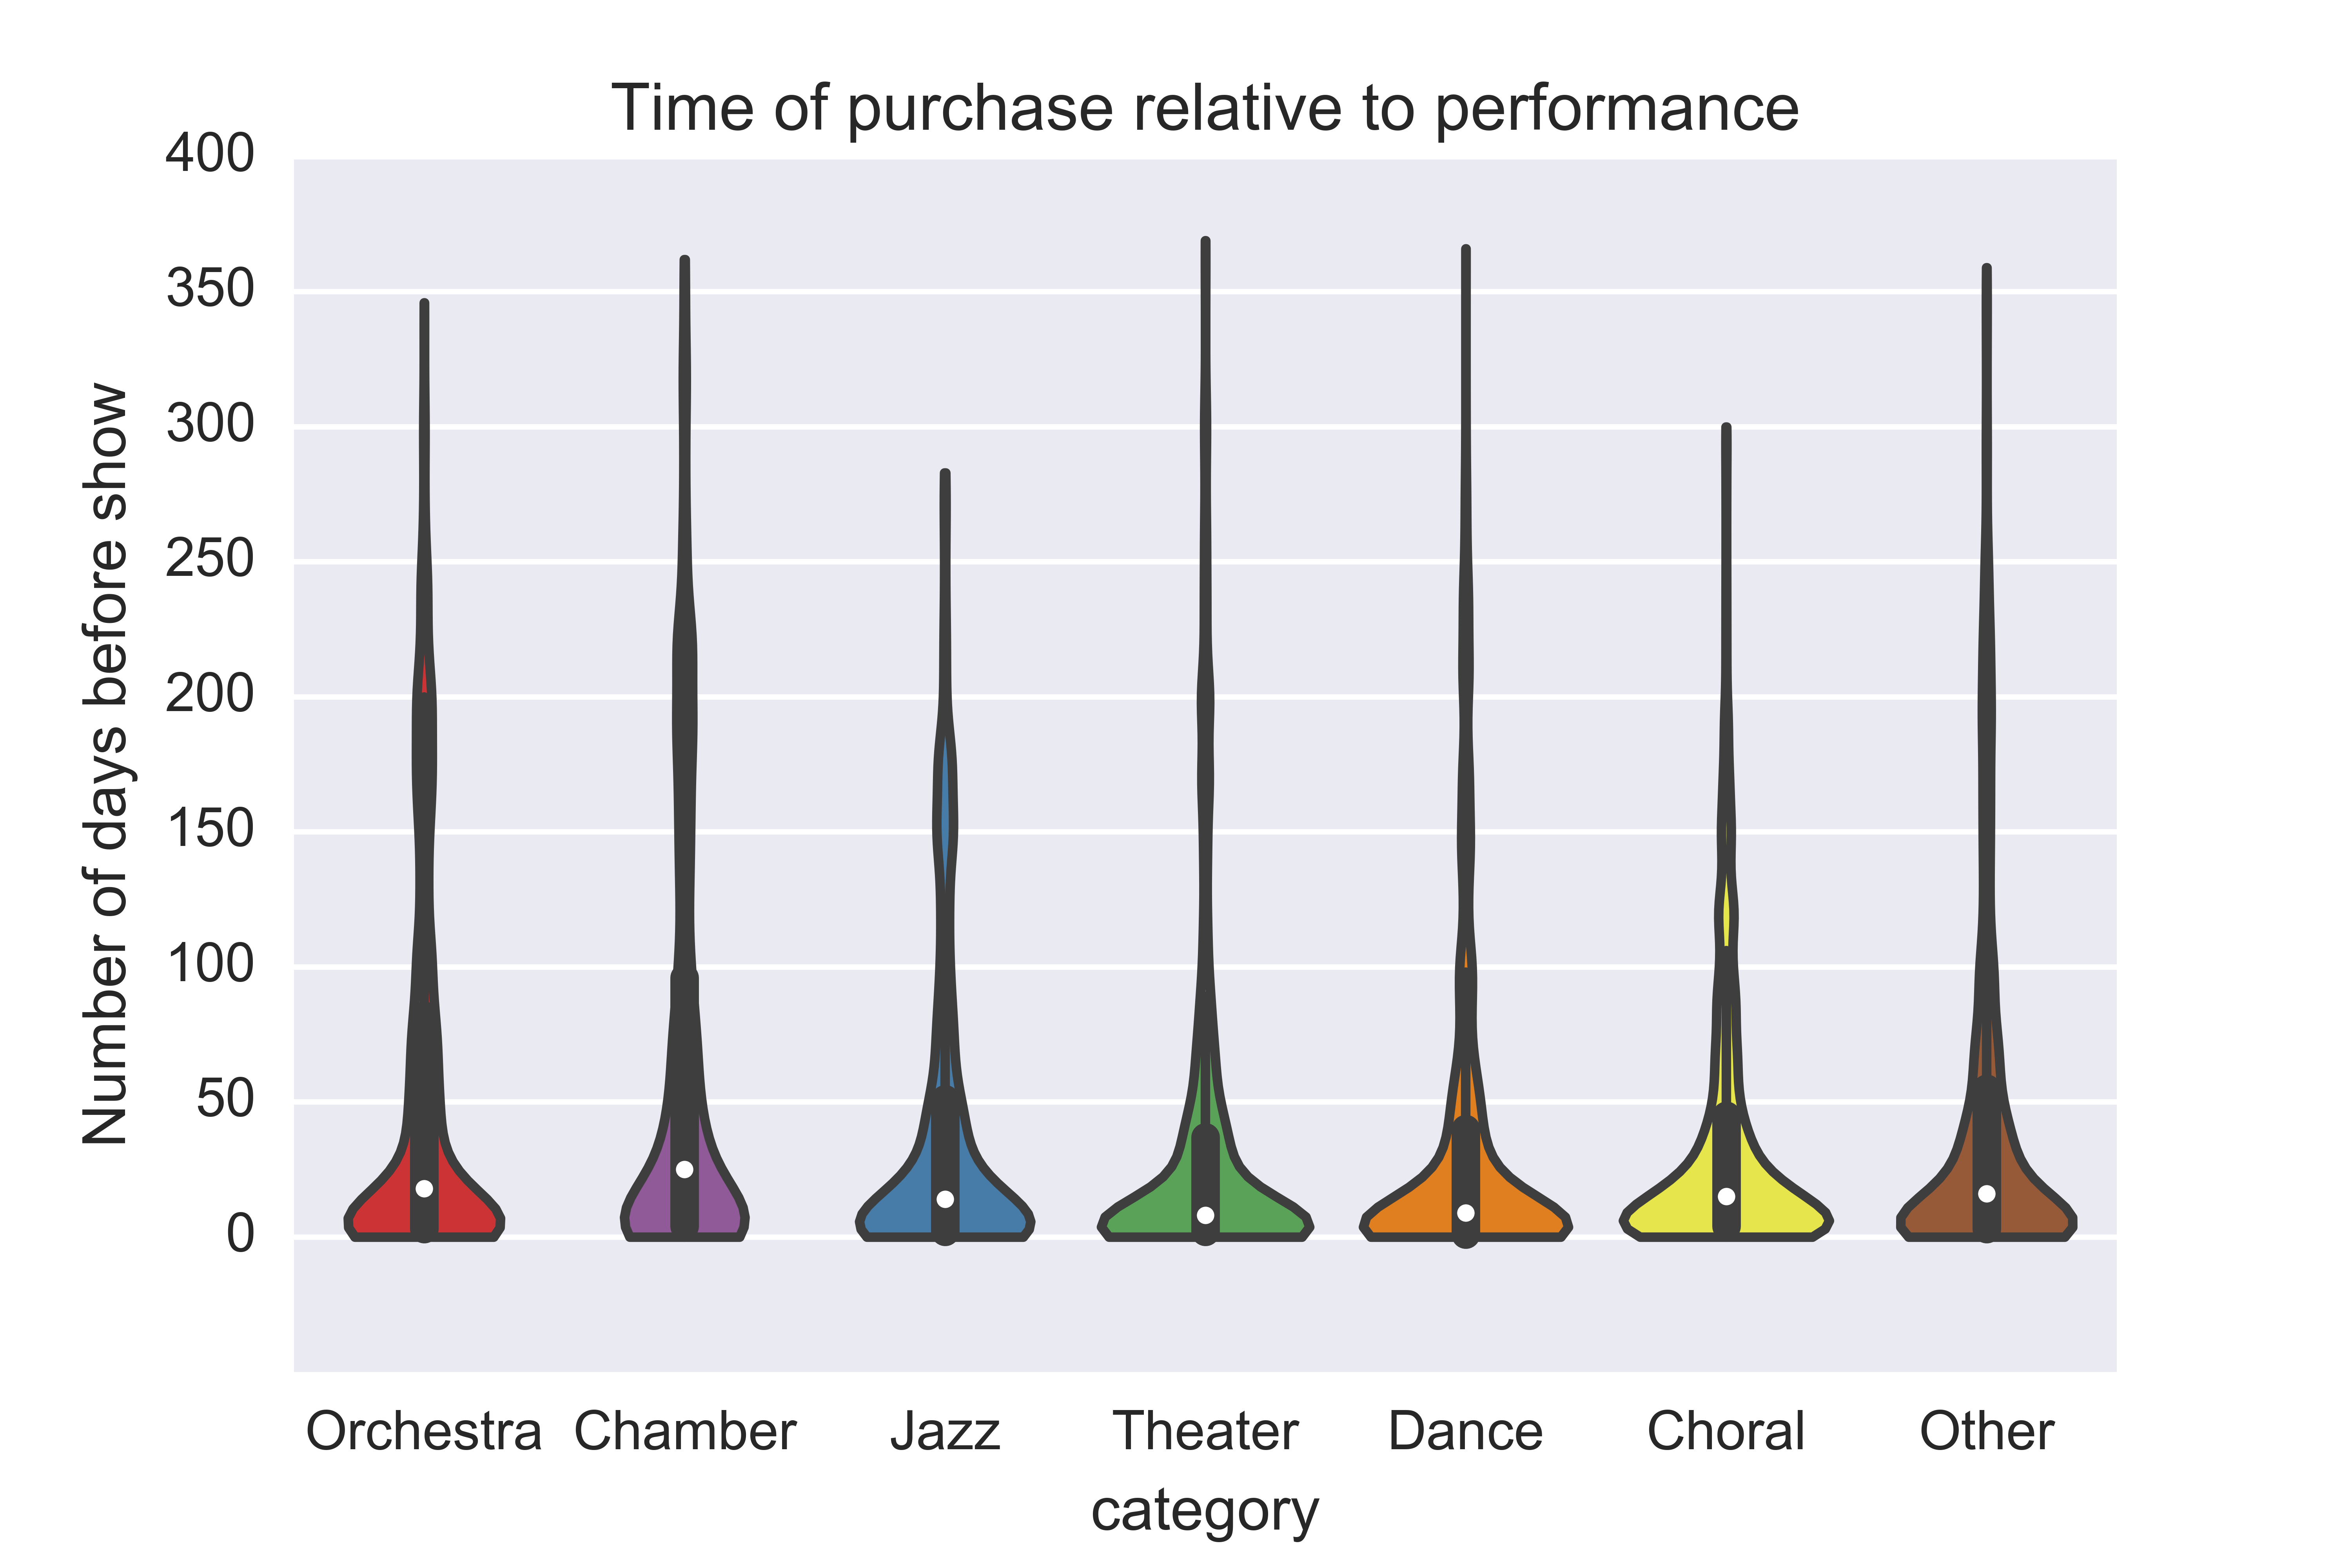

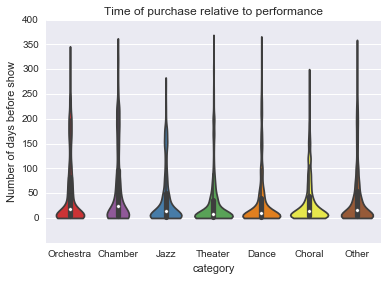

In [131]:
# When do people buy tickets?

# Some things to focus on:
# - difference between perf_date and purchase time (be careful about outliers)
# - show times / number of shows
# - price of tickets leading up to show time
# - number of tickets leading up to show time
tbl['time_delta'] = tbl['perf_dt'] - tbl['order_dt']

#no_subs = tbl
#no_subs['Subscription'] = tbl['mode_of_sale']=='Subscription'
no_subs = tbl[np.invert(tbl['mode_of_sale']=='Subscription')]

no_subs = no_subs.rename(columns={'perf_name': 'title'})
no_subs['title'] = no_subs['title'].apply(lambda x: x.strip())
no_subs = no_subs.merge(desc_tbl, how='right', on = 'title')

no_subs['td_days'] = no_subs['time_delta'].apply(lambda x: max(x.days,0))
no_subs['td_days_log'] = no_subs['time_delta'].apply(lambda x: np.log10(max(x.days + 1, 1)))

cats = ['Orchestra', 'Chamber', 'Jazz', 'Theater', 'Dance', 'Choral', 'Other']
colors = {'Orchestra': '#e41a1c',
          'Chamber': '#984ea3',
          'Jazz': '#377eb8',
          'Theater': '#4daf4a',
          'Dance': '#ff7f00',
          'Choral': '#ffff33',
          'Other': '#a65628'}
pal = sns.color_palette([colors[k] for k in cats])

g = sns.violinplot(x='category', y='td_days', data = no_subs, palette=pal, split=True, order=cats, cut=0)
#a = g.figure.get_axes()[0]
#sns.factorplot(x='category', y='td_days', data = no_subs, palette=pal, estimator = np.median, order=cats, cut=0)#, ax=a)

g.figure.get_axes()[0].set_yticks(np.arange(0, 401, 50))
g.figure.get_axes()[0].set_yticklabels(np.arange(0, 401, 50))
g.figure.get_axes()[0].set_ylabel('Number of days before show')
g.figure.get_axes()[0].set_title('Time of purchase relative to performance')

#g.figure.get_axes()[0].set_yscale('log')

g = g.figure
a = g.get_axes()[0]
plt.savefig('timedelta.png', dpi = 1000)

from IPython.display import Image
Image('timedelta.png')
#delta_tbl = no_subs.groupby('category')['time_delta'].reset_index().rename(columns={'perf_name': 'title'})

In [132]:


sns.barplot(x = 'category', y = 'num_purchases')

,UMS_acct_no,acct_created,cust_type,perf_name,perf_dt,tck_amt,num_seats,venue,price_type,price_type_group,mode_of_sale,sales_channel,order_dt,postal_code,time_delta,Subscription
0,1111,1979-08-06 00:00:00.000,Household,The Infernal Comedy,2011-10-01 20:00:00,112.0,2,Hill Auditorium,Choral Union,Subs Prices,Subscription,Fax,2011-05-31 00:00:00.000,48103,123 days 20:00:00,True
1,1111,1979-08-06 00:00:00.000,Household,"Yuja Wang, piano",2011-10-09 16:00:00,80.0,2,Hill Auditorium,Choral Union,Subs Prices,Subscription,Fax,2011-05-31 00:00:00.000,48103,131 days 16:00:00,True
2,1111,1979-08-06 00:00:00.000,Household,London Philharmonic,2011-12-06 19:30:00,112.0,2,Hill Auditorium,Choral Union,Subs Prices,Subscription,Fax,2011-05-31 00:00:00.000,48103,189 days 19:30:00,True
3,1111,1979-08-06 00:00:00.000,Household,Hamburg Symphony,2012-01-29 16:00:00,92.0,2,Hill Auditorium,Choral Union,Subs Prices,Subscription,Fax,2011-05-31 00:00:00.000,48103,243 days 16:00:00,True
4,1111,1979-08-06 00:00:00.000,Household,Chicago Symphony Orc,2012-03-09 20:00:00,140.0,2,Hill Auditorium,Choral Union,Subs Prices,Subscription,Fax,2011-05-31 00:00:00.000,48103,283 days 20:00:00,True
5,1111,1979-08-06 00:00:00.000,Household,San Francisco Sympho,2012-03-23 20:00:00,56.0,1,Hill Auditorium,Choral Union,Subs Prices,Subscription,Fax,2011-05-31 00:00:00.000,48103,297 days 20:00:00,True
6,1111,1979-08-06 00:00:00.000,Household,San Francisco Sympho,2012-03-24 20:00:00,112.0,2,Hill Auditorium,Choral Union,Subs Prices,Subscription,Fax,2011-05-31 00:00:00.000,48103,298 days 20:00:00,True
7,1111,1979-08-06 00:00:00.000,Household,Pavel Haas Quartet,2012-04-18 19:30:00,72.0,2,Rackham Auditorium,Adult,Regular Prices,Phone/Mail,Phone,2012-03-02 09:04:00.000,48103,47 days 10:26:00,False
8,1111,1979-08-06 00:00:00.000,Household,Ballet Preljocaj,2012-04-21 20:00:00,96.0,2,Power Center,Adult inc 1,Regular Prices,Subs Return/Exchange,Walk Up - League,2012-03-21 12:04:06.000,48103,31 days 07:55:54,False
9,1111,1979-08-06 00:00:00.000,Household,Joshua Bell,2012-04-22 16:00:00,112.0,2,Hill Auditorium,Choral Union,Subs Prices,Subscription,Fax,2011-05-31 00:00:00.000,48103,327 days 16:00:00,True


In [182]:
tbl['seat_cost'] = tbl['tck_amt']/tbl['num_seats']
count_tbl = tbl.groupby('perf_name')['num_seats'].sum().reset_index().rename(columns={'perf_name': 'title'})
cost_tbl = tbl.groupby('perf_name')['tck_amt'].sum().reset_index().rename(columns={'perf_name': 'title'})
seat_cost_tbl = tbl.groupby('perf_name')['seat_cost'].median().reset_index().rename(columns={'perf_name': 'title'})

desc_tbl.set_index('title')
count_tbl.set_index('title')
cost_tbl.set_index('title')
seat_cost_tbl.set_index('title')

desc_tbl = desc_tbl.join(count_tbl, how='inner', rsuffix='_')
desc_tbl = desc_tbl.join(cost_tbl, how='inner', rsuffix='_')
desc_tbl = desc_tbl.join(seat_cost_tbl, how='inner', rsuffix='_')
desc_tbl = desc_tbl.drop('num_seats_', axis = 1)
desc_tbl = desc_tbl.drop('tck_amt_', axis = 1)
desc_tbl = desc_tbl.drop('seat_cost_', axis = 1)
desc_tbl = desc_tbl.drop('title_', axis = 1)



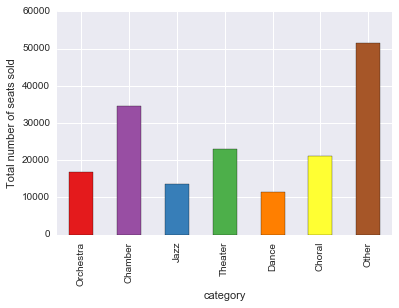

In [166]:
#print(desc_tbl['category'])
#print(desc_tbl['num_seats'])
f = desc_tbl.groupby('category')['num_seats'].sum().loc[cats].plot(kind='bar', colors = [colors[k] for k in cats])
f.set_ylabel('Total number of seats sold')


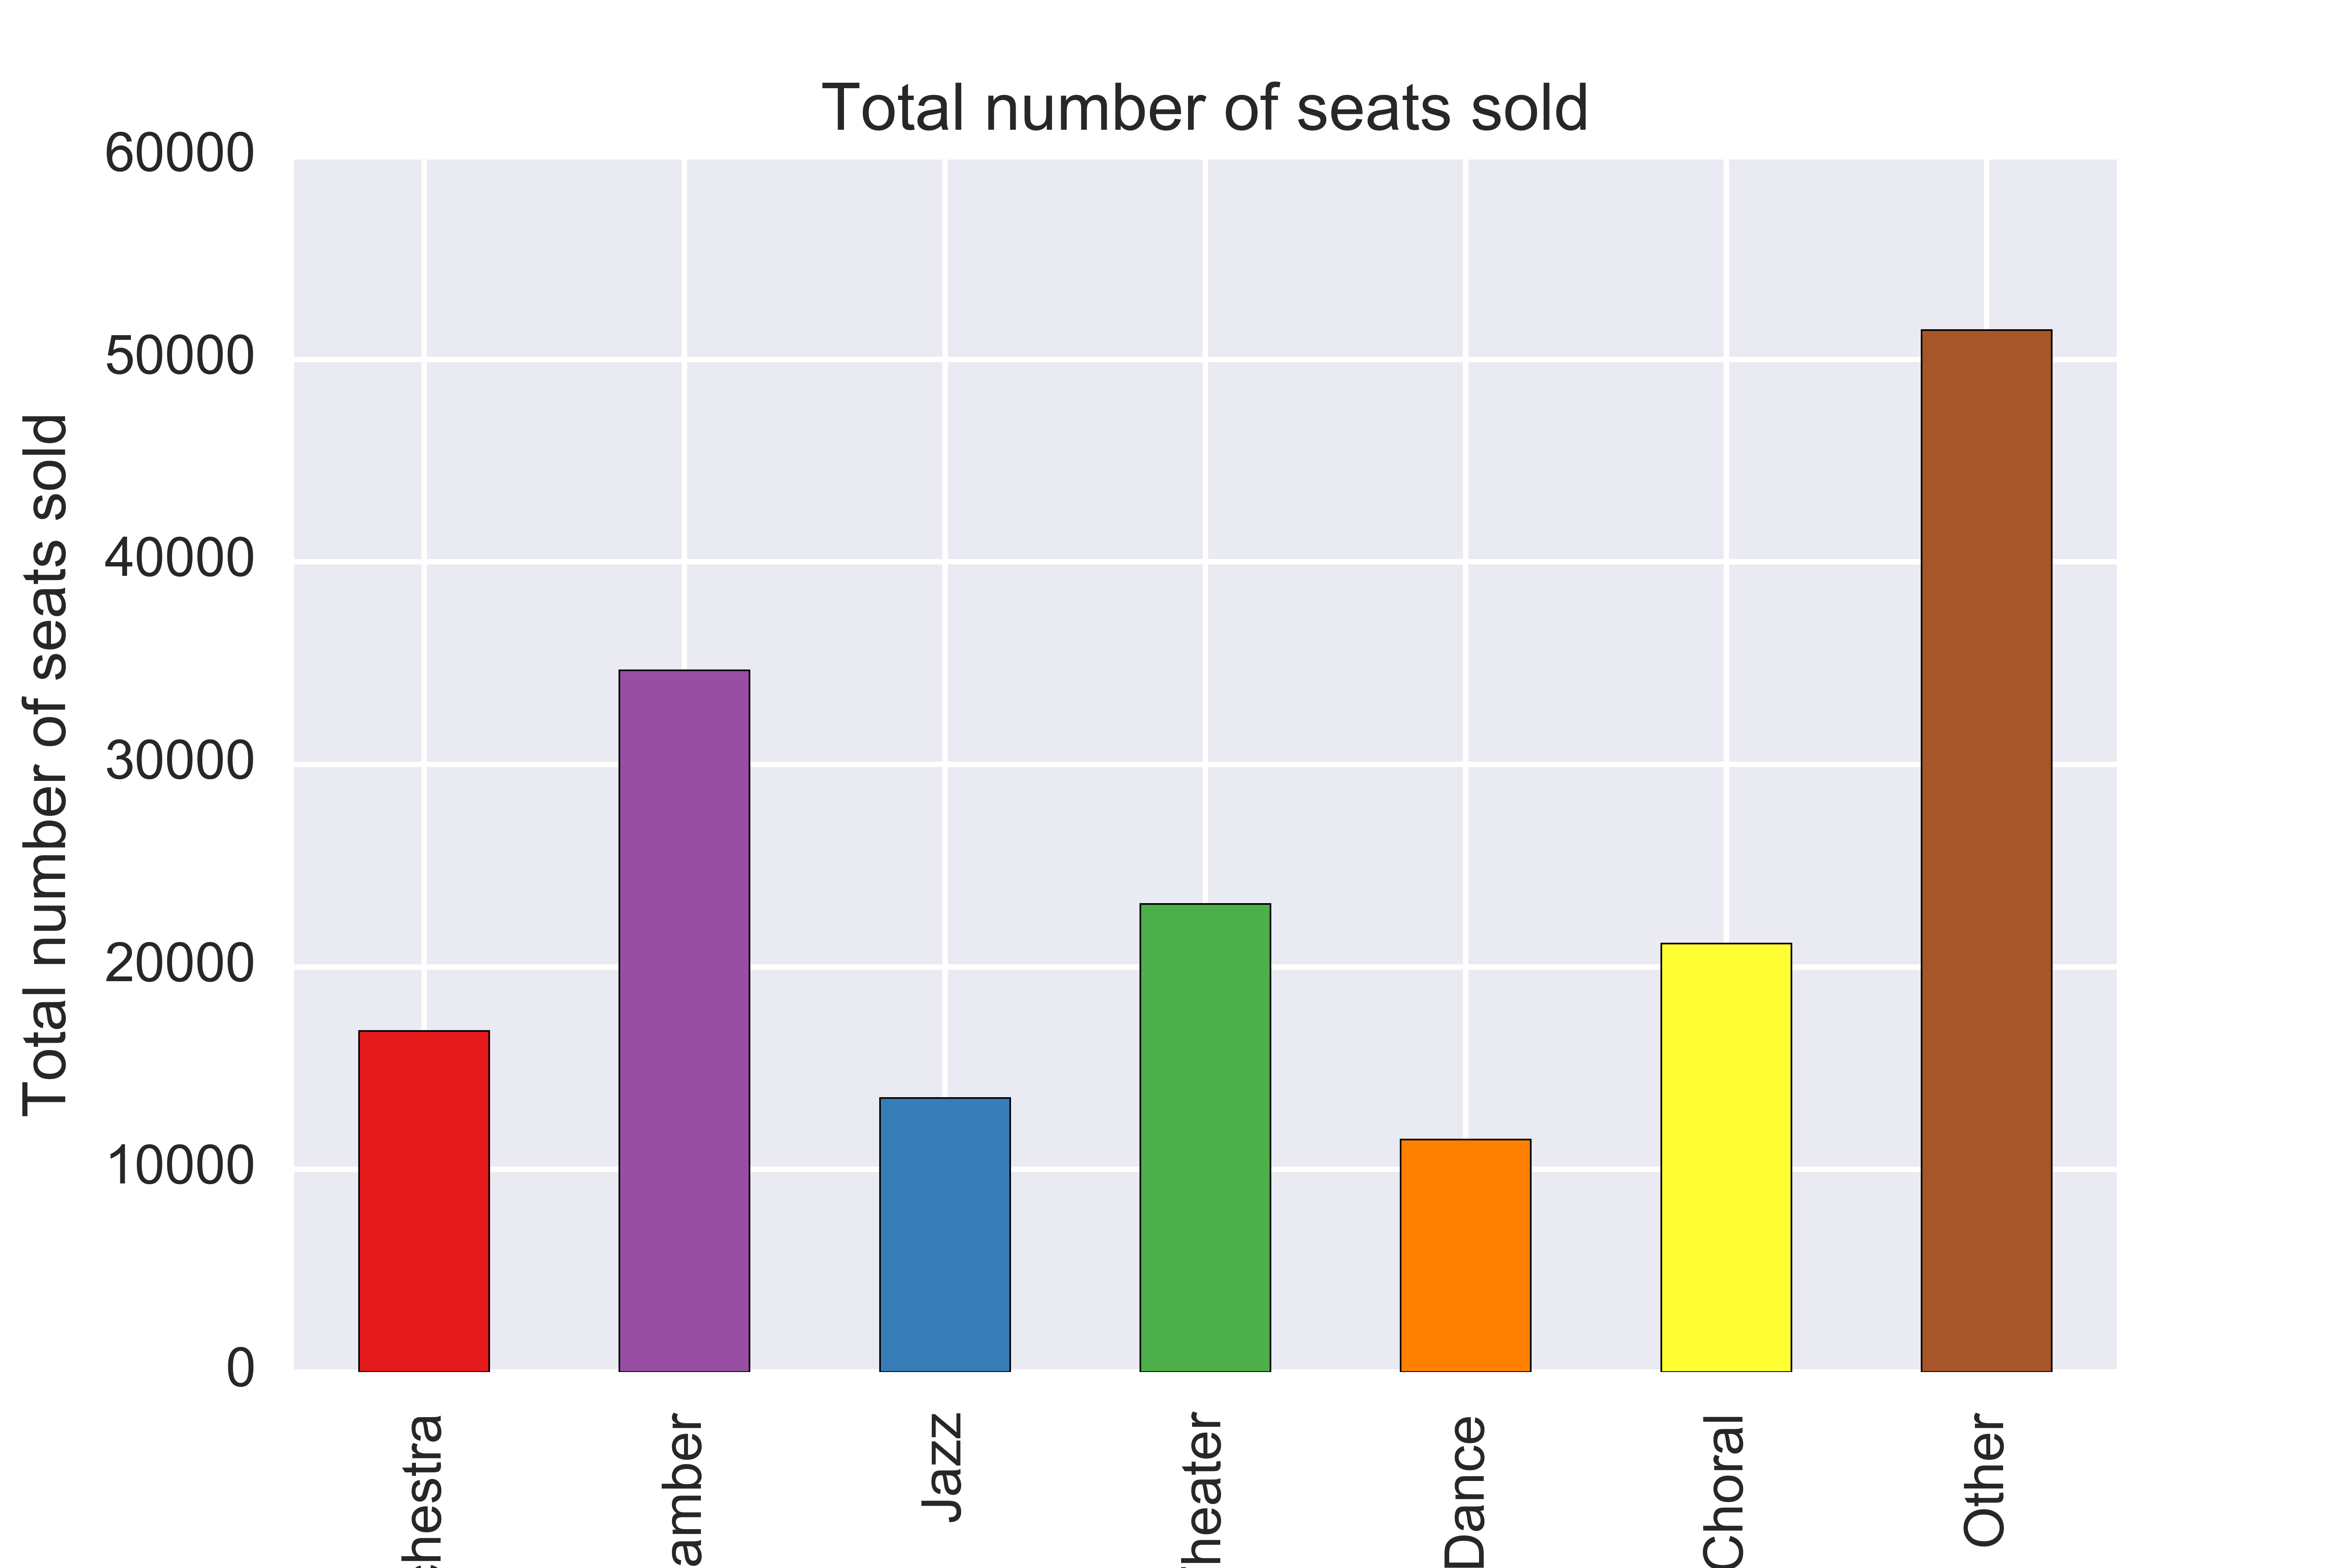

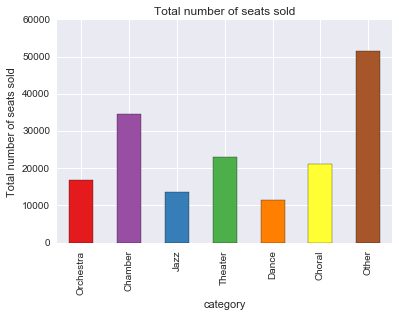

In [192]:
f = desc_tbl.groupby('category')['num_seats'].sum().loc[cats].plot(kind='bar', colors = [colors[k] for k in cats])
f.set_ylabel('Total number of seats sold')

f.set_title('Total number of seats sold')
plt.savefig('seats_sold_genre.png', dpi=1000)

Image('seats_sold_genre.png')


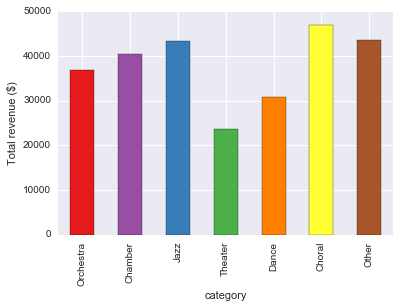

In [178]:
f = desc_tbl.groupby('category')['tck_amt'].median().loc[cats].plot(kind='bar', colors = [colors[k] for k in cats])
f.set_ylabel('Total revenue ($)')


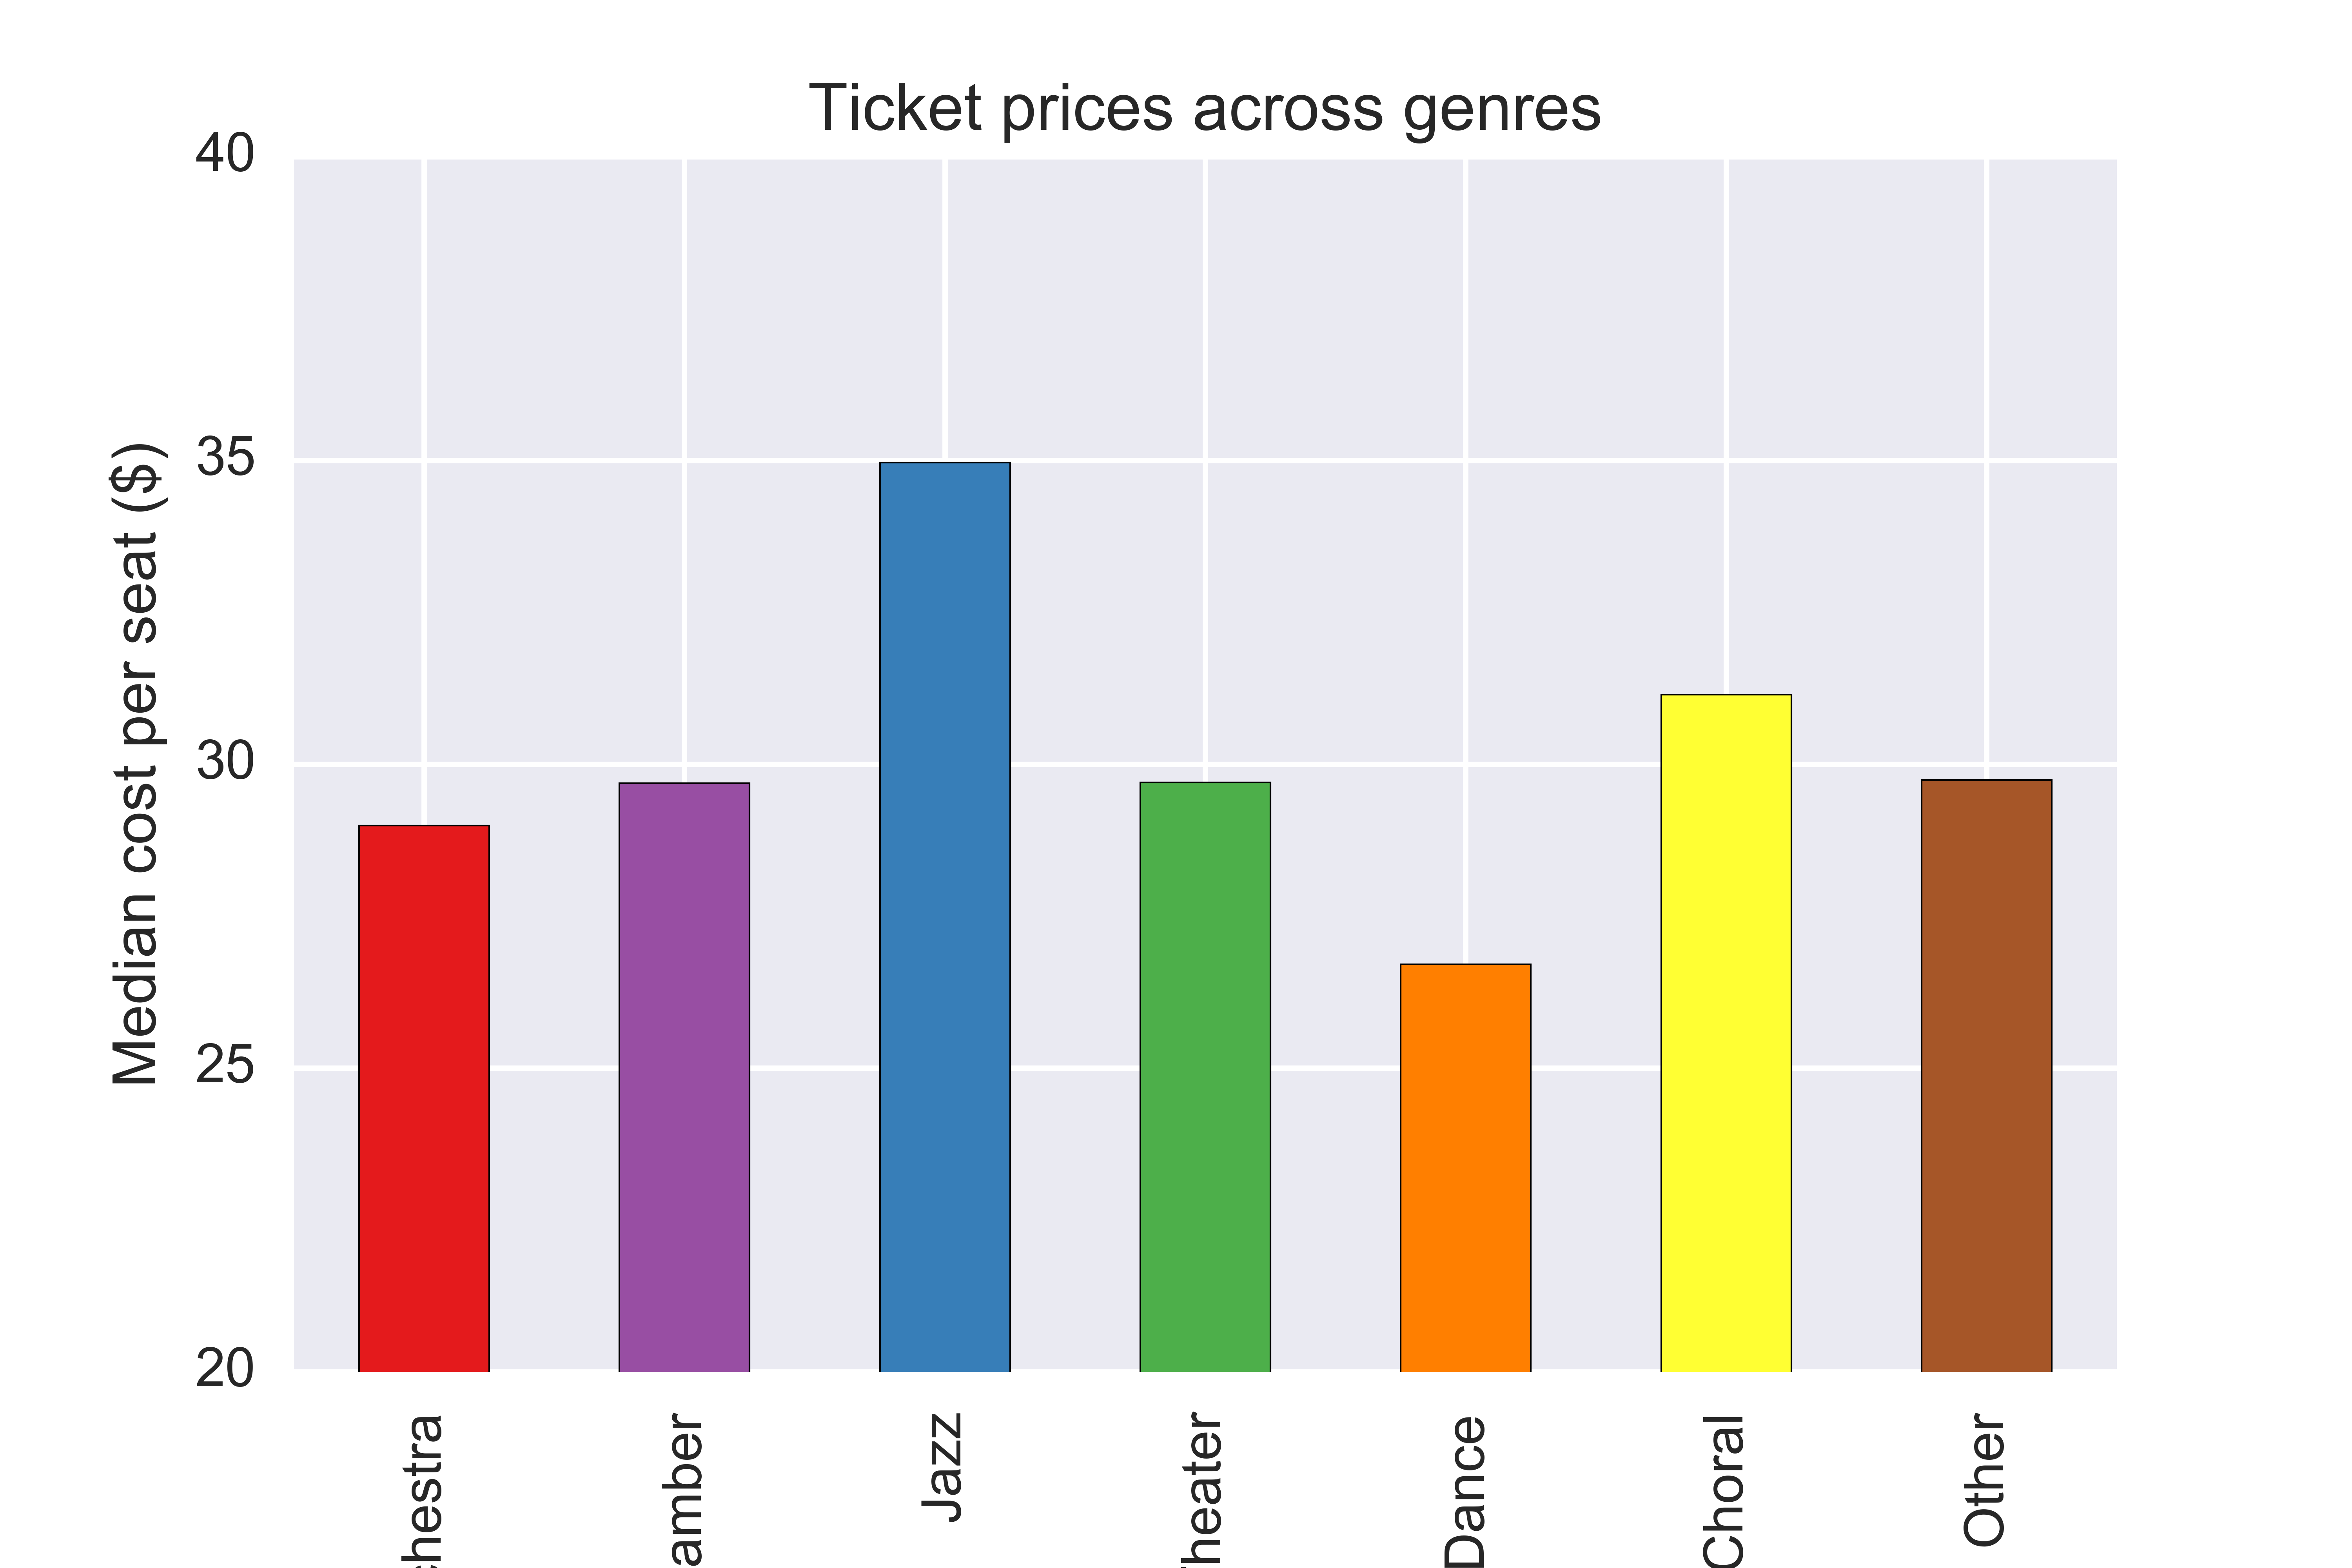

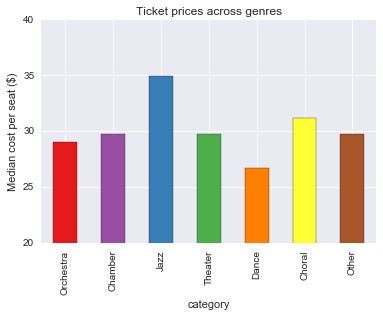

In [190]:
f = desc_tbl.groupby('category')['seat_cost'].median().loc[cats].plot(kind='bar', colors = [colors[k] for k in cats])
f.set_ylabel('Median cost per seat ($)')
f.set_title('Ticket prices across genres')
f.set_ylim([20, 40])
plt.savefig('tck_price_genre.png', dpi=1000)

Image('tck_price_genre.png')

In [ ]:
wenttoshow.shape

In [9]:
# Extract some person-level features
person_tbl = pd.DataFrame({'UMS_acct_no': tbl['UMS_acct_no'].unique()})
print tbl.head()
tbl.groupby('UMS_acct_no')

   UMS_acct_no acct_created  cust_type             perf_name  \
0         1111   1979-08-06  Household   The Infernal Comedy   
1         1111   1979-08-06  Household      Yuja Wang, piano   
2         1111   1979-08-06  Household   London Philharmonic   
3         1111   1979-08-06  Household      Hamburg Symphony   
4         1111   1979-08-06  Household  Chicago Symphony Orc   

              perf_dt  tck_amt  num_seats            venue    price_type  \
0 2011-10-01 20:00:00      112          2  Hill Auditorium  Choral Union   
1 2011-10-09 16:00:00       80          2  Hill Auditorium  Choral Union   
2 2011-12-06 19:30:00      112          2  Hill Auditorium  Choral Union   
3 2012-01-29 16:00:00       92          2  Hill Auditorium  Choral Union   
4 2012-03-09 20:00:00      140          2  Hill Auditorium  Choral Union   

  price_type_group  mode_of_sale sales_channel   order_dt postal_code  
0      Subs Prices  Subscription           Fax 2011-05-31       48103  
1      Subs Pr

In [10]:
print "Columns:"
for col in tbl.columns.tolist():
    
    print "\t%16s" % col + " : " + str(tbl[col].dtype)


Columns:
	     UMS_acct_no : int64
	    acct_created : datetime64[ns]
	       cust_type : object
	       perf_name : object
	         perf_dt : datetime64[ns]
	         tck_amt : float64
	       num_seats : int64
	           venue : object
	      price_type : object
	price_type_group : object
	    mode_of_sale : object
	   sales_channel : object
	        order_dt : datetime64[ns]
	     postal_code : object


In [11]:
# Print some important statistics

no_orders = len(tbl['UMS_acct_no'])
no_accts = len(np.unique(tbl['UMS_acct_no']))
acct_no_val_cts = tbl['UMS_acct_no'].value_counts()
order_no_val_cts = acct_no_val_cts.value_counts()

print "Number of ticket_purchases:               ", no_orders
print "Number of unique UMS account IDs:         ", no_accts
print "Maximum no. of purchases on one account:  ", acct_no_val_cts.iloc[0]
print "Fraction of accts with just one purchase: ", order_no_val_cts.loc[1]/float(no_accts)
print "Mean number of purchases per account:     ", no_orders/float(no_accts)

Number of ticket_purchases:                104737
Number of unique UMS account IDs:          30325
Maximum no. of purchases on one account:   358
Fraction of accts with just one purchase:  0.562374278648
Mean number of purchases per account:      3.45381698269


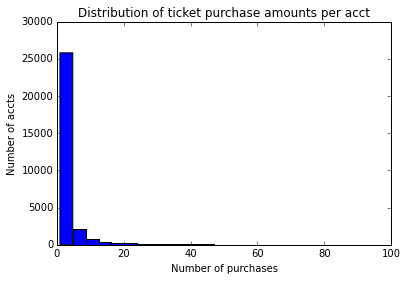

In [12]:
plt.hist(acct_no_val_cts.loc[acct_no_val_cts < 100].tolist(), bins=25)
plt.title('Distribution of ticket purchase amounts per acct')
plt.xlabel('Number of purchases')
plt.ylabel('Number of accts')
plt.show()


        UMS_acct_no            acct_created   cust_type
0              1111 1979-08-06 00:00:00.000   Household
29             1115 1988-02-18 00:00:00.000   Household
62             1122 1988-02-10 00:00:00.000   Household
63             1130 1988-02-26 00:00:00.000   Household
71             1131 1988-02-26 00:00:00.000   Household
91             1134 1988-02-26 00:00:00.000   Household
92             1143 1988-02-10 00:00:00.000  Individual
140            1147 1988-02-10 00:00:00.000   Household
158            1152 1988-02-10 00:00:00.000  Individual
174            1153 1988-02-10 00:00:00.000   Household
207            1159 1988-02-10 00:00:00.000  Individual
209            1165 1988-02-16 00:00:00.000   Household
246            1166 1988-02-26 00:00:00.000   Household
258            1168 1988-02-10 00:00:00.000  Individual
261            1174 1988-02-26 00:00:00.000  Individual
268            1175 1988-02-10 00:00:00.000  Individual
288            1181 1988-02-26 00:00:00.000  Ind

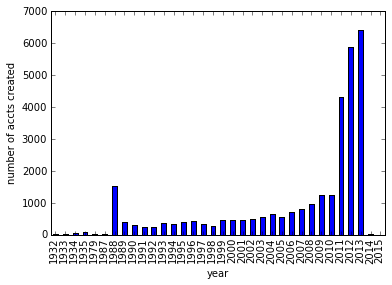

In [13]:
# Load account-level table

acc_tbl = tbl[['UMS_acct_no', 'acct_created', 'cust_type']]
acc_tbl = acc_tbl.drop_duplicates()
print(acc_tbl)

# plot accounts created by year
acc_tbl['acct_created'].groupby(acc_tbl['acct_created'].dt.year).count().plot(kind="bar")
plt.xlabel('year')
plt.ylabel('number of accts created')
plt.show()

In [21]:
grpAcct = tbl.groupby('UMS_acct_no')

grpAcct['mode_of_sale'].agg(lambda x : x.eq('Subscription').any())

UMS_acct_no
1111       True
1115       True
1122      False
1130      False
1131       True
1134      False
1143       True
1147      False
1152       True
1153       True
1159      False
1165      False
1166      False
1168      False
1174       True
1175       True
1181       True
1182       True
1183      False
1186       True
1189      False
1201       True
1215      False
1217       True
1223      False
1224       True
1227       True
1228      False
1245       True
1248       True
          ...  
304396    False
304400     True
304420    False
304437    False
304451    False
304471    False
304589    False
304599    False
304621    False
304640    False
304651    False
304652    False
304655    False
304684    False
304691    False
304800    False
304806    False
304858    False
304918    False
304994    False
305118    False
305272    False
305313    False
305320    False
305336    False
305468    False
305484    False
305645    False
305688    False
305834    False
Name: mode_o

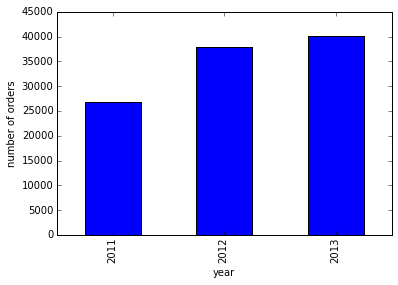

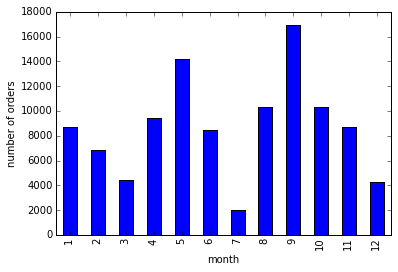

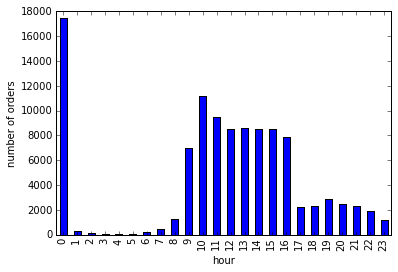

In [9]:
# show orders by year, month, hour
tbl['order_dt'].groupby(tbl['order_dt'].dt.year).count().plot(kind="bar")
plt.xlabel('year')
plt.ylabel('number of orders')
plt.show()
tbl['order_dt'].groupby(tbl['order_dt'].dt.month).count().plot(kind="bar")
plt.xlabel('month')
plt.ylabel('number of orders')
plt.show()
tbl['order_dt'].groupby(tbl['order_dt'].dt.hour).count().plot(kind="bar")
plt.xlabel('hour')
plt.ylabel('number of orders')
plt.show()

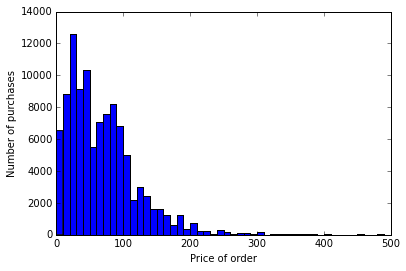

In [10]:
# show hist of ticket prices
plt.hist(tbl['tck_amt'].loc[tbl['tck_amt']<500], bins=50)
plt.xlabel('Price of order')
plt.ylabel('Number of purchases')
plt.show()

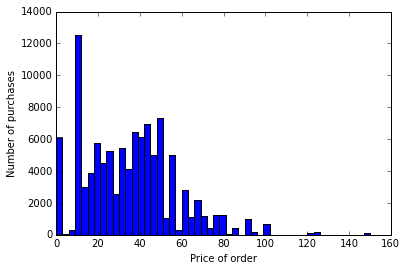

In [11]:
# show hist of ticket prices normalized by number of seats
norm_tck_price = tbl['tck_amt']/tbl['num_seats']
plt.hist(norm_tck_price.loc[norm_tck_price < 200], bins=50)
plt.xlabel('Price of order')
plt.ylabel('Number of purchases')
plt.show()

In [12]:
# Let's look at some of the categorical variables

acc_tbl.groupby('cust_type')['cust_type'].count()

cust_type
Household        2594
Individual      27520
Organization      211
Name: cust_type, dtype: int64

In [13]:
tbl.groupby('venue')['venue'].count()

venue
Arthur Miller Theatre              664
Corner Brewery                     405
Dance Club                          39
Demo Theater                         5
Downtown Home & Garden             280
General Admission (Education)       54
Hill Auditorium                  60539
Lydia Mendelssohn Theatre          752
Michigan Theater                  7806
Music Hall                         175
Performance Network                882
Power Center                     21468
Rackham Auditorium                9264
St Andrew's Episcopal Church       280
St. Francis of Assisi Church      2124
Name: venue, dtype: int64

In [14]:
print tbl.groupby('price_type')['price_type'].count()

print "Number of price types:", len(np.unique(tbl['price_type']))

price_type
$10 Off                           472
$10 off inc 1                      92
$10 off inc 2                       6
$5 Off                              4
20% off                            22
50% off                           176
AARP Discount                       2
Adult                           39204
Adult inc 1                      2411
Adult inc 2                      1305
Adult inc 3                       414
Arts & Eats                      1082
Asia Series                        36
Bert's Ticket                     220
Buy one get one free               15
Chamber Arts                     2748
Child                             209
Child Under 2                      14
Choral Union                    10871
Chorus Comp                        83
Chorus Member                     557
Comp                             5131
Dance Series                     1219
Discount                          627
Discount 2                         93
Discount Student                   12
D

In [15]:
print tbl.groupby('price_type_group')['price_type_group'].count()

price_type_group
Comps                  5307
Discounted Prices      2690
Group Prices           1971
Promotional Prices     2943
Regular Prices        43651
Student Prices        17192
Subs Prices           30983
Name: price_type_group, dtype: int64


In [16]:
print tbl.groupby('mode_of_sale')['mode_of_sale'].count()

mode_of_sale
Arts and Eats                      578
Bert's Ticket                      220
Door Rush Tickets                  261
Education                           10
Group Promotions                    72
Group Sales                       2391
Night of Show                     1717
Phone/Mail                       11368
Rush Bucks Tickets                 399
Rush Tickets                      3284
Single Return/Exchange             724
Student Half Price                4838
Subs Return/Exchange              1946
Subscription                     28559
UMS 48 hr Return/Exchange           86
UMS Dept Requests                 4056
Walk Up                          11203
Web - UMS - $10 off                108
Web - UMS - $5 off                  60
Web - UMS - 25% off                146
Web - UMS - AARP                     2
Web - UMS - Arts and Eats          464
Web - UMS - BOGO                     3
Web - UMS - CU Rush                196
Web - UMS - Discounts              721
Web - UMS - 

In [17]:
print tbl.groupby('sales_channel')['sales_channel'].count()

sales_channel
Comp Form                   461
Customer Service Issue     3204
E-Mail                      651
Fax                         195
Google form                 221
In-Person (Devo)             34
Mail                       3784
Night of Show - Venue      1982
Order Import                 17
Phone                     34643
UM-OUD                        1
Walk Up - League          22630
Web-Cybersource            1072
Web-TNEW                  33641
ums.org                    2201
Name: sales_channel, dtype: int64


In [19]:
print tbl['postal_code'].value_counts()

48104        19385
48103        18693
48105        16088
99999         4053
48108         3860
48197         2142
48130         1527
48176         1162
48109          888
48118          810
48198          787
48170          776
48322          475
48116          452
48187          437
48302          424
48823          403
48188          385
48167          379
48009          338
48168          335
48178          322
48323          320
48025          316
999999999      295
48189          270
48864          261
48331          260
48169          259
48236          246
             ...  
480801537        1
100123618        1
21394656         1
N9G2T7           1
276031908        1
602022324        1
481035602        1
605639220        1
75067            1
805254617        1
49938            1
481873005        1
46703            1
62703            1
487070285        1
7731             1
981156206        1
42085            1
77498            1
91942            1
91941            1
89117       

In [20]:
tbl['postal_code']


0         48103
1         48103
2         48103
3         48103
4         48103
5         48103
6         48103
7         48103
8         48103
9         48103
10        48103
11        48103
12        48103
13        48103
14        48103
15        48103
16        48103
17        48103
18        48103
19        48103
20        48103
21        48103
22        48103
23        48103
24        48103
25        48103
26        48103
27        48103
28        48103
29        48105
          ...  
104707    48376
104708    48098
104709    48104
104710    48108
104711    48108
104712    48104
104713    48104
104714    48209
104715    48209
104716    48009
104717    48009
104718    48009
104719    48104
104720    48104
104721    48187
104722    48154
104723    48169
104724    48104
104725    48105
104726    49240
104727    48105
104728    48105
104729    48105
104730    48105
104731    48105
104732    48105
104733    48105
104734    48375
104735    48197
104736    48197
Name: postal_code, dtype